<a href="https://colab.research.google.com/github/JacobSchmitt/Basaa-Machine-Learning/blob/main/Basaa_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Files

In [1]:
%%capture
!wget -P '/content/baseline' https://raw.githubusercontent.com/JacobSchmitt/Basaa-Machine-Learning/main/basaa/baseline/train.py
!wget -P '/content/baseline' https://raw.githubusercontent.com/JacobSchmitt/Basaa-Machine-Learning/main/basaa/baseline/convert.py
!wget -P '/content/baseline' https://raw.githubusercontent.com/JacobSchmitt/Basaa-Machine-Learning/main/basaa/baseline/Makefile
!wget https://raw.githubusercontent.com/JacobSchmitt/Basaa-Machine-Learning/main/basaa/evaluate.py
!wget -P '/content/data' https://raw.githubusercontent.com/JacobSchmitt/Basaa-Machine-Learning/main/basaa/data/train.tsv 
!wget -P '/content/data' https://raw.githubusercontent.com/JacobSchmitt/Basaa-Machine-Learning/main/basaa/data/dev.tsv 

# Run Baseline

In [ ]:
%%bash
cd baseline
make

python3 train.py ../data/train.tsv model.tsv
Stored 14596 words
python3 convert.py model.tsv < ../data/dev.tsv > output.tsv
python3 ../evaluate.py ../data/dev.tsv output.tsv
CER: 16.54687852515551
WER: 40.88336922205728


# Explore the data

In [2]:
import matplotlib.pyplot as plt
from string import punctuation
import sys
import difflib
import numpy
from difflib import SequenceMatcher
punct = punctuation + "«»—…“”"
from collections import Counter
import numpy as np
plt.rcParams['figure.figsize'] = [20, 6]

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

In [4]:
train = pd.read_csv('./data/train.tsv', sep ='\t', names = ['Protestant', 'Academy'])
test = pd.read_csv('./data/dev.tsv', sep ='\t', names = ['Protestant', 'Academy'])

In [ ]:
train.head()

,Protestant,Academy
0,Ti me bot yem.,Ti mɛ̀ ɓɔ̀t yɛ̂m.
1,Mimañ mi bôdaa mi ñañna ni jomol.,Mı̀maŋ mi ɓodàa mi ŋâŋnā ni jɔ̀mɔ̂l.
2,"Me bibagla ni bôt bem, me bibagla bôt bem.","Mɛ̀ biɓāgla ni ɓòt ɓɛ̂m, mɛ̀ biɓāgla ɓôt ɓɛ̂m."
3,"Nu a ñôm bés ni béé makôô isi siñ siñ i Kristô... (2kor.1,21).","Nu à ŋōm ɓes nı̀ ɓèe makòò isı̄ sı̂ŋ sı̀ŋ i Krı̌stò... (2Kɔ̀r.1,21)."
4,"Me galo ga ha, ni tehe.","Mɛ̀ galɔ̀ ga hâ, ni tɛhɛ."


In [ ]:
train['Academy'].isna().sum()

2

In [ ]:
train['Protestant'].isna().sum()

0

We have rows with missing values, so let's drop them

In [5]:
train = train.dropna()

In [ ]:
def wordlist(x): 
  y = x.strip(punct)
  return set(y.split())

In [ ]:
train['word2convert'] = train['Protestant'].apply(wordlist) - train['Academy'].apply(wordlist)

In [ ]:
train.head()

,Protestant,Academy,word2convert
0,Ti me bot yem.,Ti mɛ̀ ɓɔ̀t yɛ̂m.,"{me, yem, bot}"
1,Mimañ mi bôdaa mi ñañna ni jomol.,Mı̀maŋ mi ɓodàa mi ŋâŋnā ni jɔ̀mɔ̂l.,"{Mimañ, jomol, ñañna, bôdaa}"
2,"Me bibagla ni bôt bem, me bibagla bôt bem.","Mɛ̀ biɓāgla ni ɓòt ɓɛ̂m, mɛ̀ biɓāgla ɓôt ɓɛ̂m.","{bem, Me, bibagla, bem,, bôt, me}"
3,"Nu a ñôm bés ni béé makôô isi siñ siñ i Kristô... (2kor.1,21).","Nu à ŋōm ɓes nı̀ ɓèe makòò isı̄ sı̂ŋ sı̀ŋ i Krı̌stò... (2Kɔ̀r.1,21).","{bés, Kristô..., (2kor.1,21, a, béé, ñôm, siñ, ni, makôô, isi}"
4,"Me galo ga ha, ni tehe.","Mɛ̀ galɔ̀ ga hâ, ni tɛhɛ.","{ha,, Me, galo, tehe}"


In [ ]:
test.head()

,Protestant,Academy
0,Malét a mbôñe hyémbi.,Màlêt à m̂ɓoŋɛ hyembi.
1,A ntuhul me két (i) nuga.,À ǹtuhul mɛ kēt (i) nugā.
2,"Ñkum u ñkôs ndoñ, ñkum u nlôôs ndoñ.","Ŋ̀kùm u ŋkòs ndɔŋ, ŋ̀kùm u nlòos ndɔŋ."
3,Mañ mut unu u nlo u mboda nyono wotama.,Maŋ mût unu u nlɔ ū mɓɔ̄da nyɔnɔ̄ wɔtāma.
4,Boñge ba ñke jogop ba kahal ndugi kôt mañgudga.,Ɓɔ̀ŋgɛ ɓa ŋkɛ̂ jɔ̀gɔ̂p ɓa kahal ndugi kòt maŋgudga.


Let's build the frequency dictionary of words that need to be converted


In [ ]:
words2_convert = train['word2convert'].tolist()

In [ ]:
list(words2_convert[:10])

[{'bot', 'me', 'yem'},
 {'Mimañ', 'bôdaa', 'jomol', 'ñañna'},
 {'Me', 'bem', 'bem,', 'bibagla', 'bôt', 'me'},
 {'(2kor.1,21',
  'Kristô...',
  'a',
  'bés',
  'béé',
  'isi',
  'makôô',
  'ni',
  'siñ',
  'ñôm'},
 {'Me', 'galo', 'ha,', 'tehe'},
 {'A', 'kwade', 'mbéhha', 'me'},
 {'Me', 'e', 'koo', 'ñwabal'},
 {'A', 'hala', 'nlem'},
 {'matjél', 'mbôô', 'me', 'Ñem'},
 {'Kôp', 'bon', 'i', 'ñkek'}]

In [ ]:
def build_vocab(data):
  vocab = []
  for i in range(len(data)):
    vocab.append(list(data[i]))
  vocab = [item for sublist in vocab for item in sublist]
  return vocab

In [ ]:
vocab = build_vocab(words2_convert)
freq_dict =  pd.Series(vocab)
vc = freq_dict.value_counts()
print(vc[:10])

a      1823
me     1352
A       979
Me      758
i       748
yé      729
ba      680
mut     497
nye     472
ni      463
dtype: int64


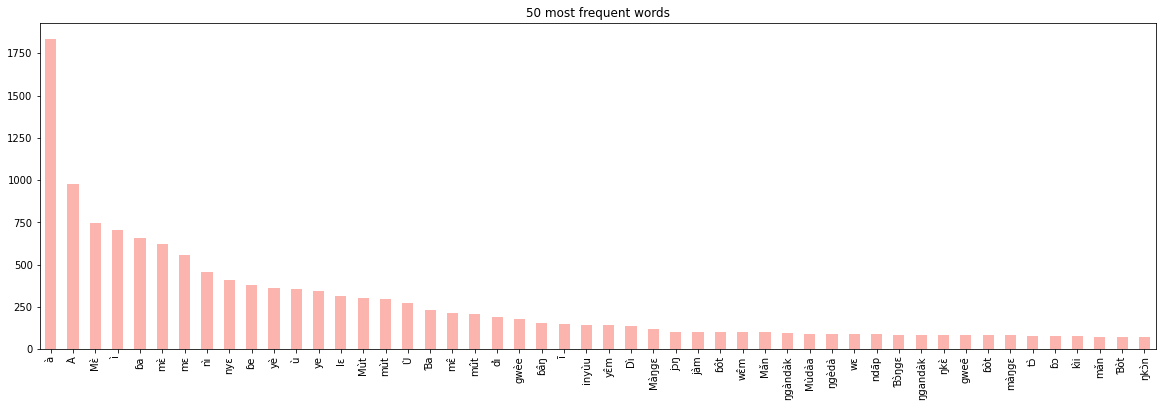

In [ ]:
_ = plt.title('50 most frequent words')
vc[:50].plot(kind='bar', colormap = 'Pastel1')

# Try different algorithms here

In [6]:
whole_text = train['Protestant'] + ' ' + train['Academy']
print(whole_text)

0                                                                                                                Ti me bot yem. Ti mɛ̀ ɓɔ̀t yɛ̂m.
1                                                                       Mimañ mi bôdaa mi ñañna ni jomol. Mı̀maŋ mi ɓodàa mi ŋâŋnā ni jɔ̀mɔ̂l.
2                                                   Me bibagla ni bôt bem, me bibagla bôt bem. Mɛ̀ biɓāgla ni ɓòt ɓɛ̂m, mɛ̀ biɓāgla ɓôt ɓɛ̂m.
3       Nu a ñôm bés ni béé makôô isi siñ siñ i Kristô... (2kor.1,21). Nu à ŋōm ɓes nı̀ ɓèe makòò isı̄ sı̂ŋ sı̀ŋ i Krı̌stò... (2Kɔ̀r.1,21).
4                                                                                              Me galo ga ha, ni tehe. Mɛ̀ galɔ̀ ga hâ, ni tɛhɛ.
                                                                          ...                                                                    
9995                                                                                                       Mudaa a ñkondop. 

In [8]:
%%capture
!pip3 install razdel

In [9]:
from razdel import tokenize as razdel_tokenize
from gensim.models.word2vec import Word2Vec
from gensim.models import FastText

def normalize(text):
    words = [word.strip(punct) for word in text.lower().split()]
    return ' '.join(words)

def tokenize(text):
    tokens = [token.text for token in list(razdel_tokenize(text))]
    tokens = [token for token in tokens if token.isalnum()]
    return ' '.join(tokens)

data_norm = [normalize(tokenize(text)) for text in whole_text]
data_norm = [text for text in data_norm if text]

fasttext = FastText([text.split() for text in data_norm], size=50, min_n=1, max_n=8) 
print('done')

done


In [ ]:
print(fasttext)

FastText(vocab=1607, size=50, alpha=0.025)


In [ ]:
print(fasttext.most_similar('ɓɔ̀t'))

[('béba', 0.9927377700805664), ('bañ', 0.9922951459884644), ('bas', 0.9916104674339294), ('bap', 0.9913110733032227), ('bay', 0.9911091327667236), ('bak', 0.9906681180000305), ('béa', 0.9906035661697388), ('bahba', 0.9901837706565857), ('ɓɔ', 0.9890789985656738), ('bo', 0.9883771538734436)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
fasttext.most_similar('ɓɔ̀t')[-1][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


'bo'

In [ ]:
def simple_fast_text(x):
  new = ''
  for i in x.split():
    i = i.strip(punct).lower()
    if i:
      y = [(a,b) for a,b in fasttext.most_similar(i) if i[0] == a[0]]
      if y:
        new += y[0][0] + ' '
      else:
        new += i + ' '
    else:
      new += i + ' '
  return new.strip(' ')

In [ ]:
train['changed'] = train['Protestant'].apply(simple_fast_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [ ]:
ac_norm = [normalize(tokenize(text)) for text in train['Academy'].tolist()]
train['norm'] = ac_norm

In [ ]:
train.head()

,Protestant,Academy,changed,norm
0,Ti me bot yem.,Ti mɛ̀ ɓɔ̀t yɛ̂m.,tjibi mt bok yom,ti
1,Mimañ mi bôdaa mi ñañna ni jomol.,Mı̀maŋ mi ɓodàa mi ŋâŋnā ni jɔ̀mɔ̂l.,masiñ mbebi batan mbebi ñañna niñi jogop,mi mi ni
2,"Me bibagla ni bôt bem, me bibagla bôt bem.","Mɛ̀ biɓāgla ni ɓòt ɓɛ̂m, mɛ̀ biɓāgla ɓôt ɓɛ̂m.",mt bisay niñi boo bikaat mt bisay boo bikaat,ni
3,"Nu a ñôm bés ni béé makôô isi siñ siñ i Kristô... (2kor.1,21).","Nu à ŋōm ɓes nı̀ ɓèe makòò isı̄ sı̂ŋ sı̀ŋ i Krı̌stò... (2Kɔ̀r.1,21).","nuu a ñom boy niñi bet matéô isi siñ siñ ii kôy 2kor.1,21",nu ɓes i 2
4,"Me galo ga ha, ni tehe.","Mɛ̀ galɔ̀ ga hâ, ni tɛhɛ.",mt galo ga hala niñi tee,ga ni tɛhɛ


In [ ]:
class WER:

    
    def editDistance(self, r, h):
        '''
        This function is to calculate the edit distance of reference sentence and the hypothesis sentence.
    
        Main algorithm used is dynamic programming.
    
        Attributes: 
            r -> the list of words produced by splitting reference sentence.
            h -> the list of words produced by splitting hypothesis sentence.
        '''
        d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8).reshape((len(r)+1, len(h)+1))
        for i in range(len(r)+1):
            d[i][0] = i
        for j in range(len(h)+1):
            d[0][j] = j
        for i in range(1, len(r)+1):
            for j in range(1, len(h)+1):
                if r[i-1] == h[j-1]:
                    d[i][j] = d[i-1][j-1]
                else:
                    substitute = d[i-1][j-1] + 1
                    insert = d[i][j-1] + 1
                    delete = d[i-1][j] + 1
                    d[i][j] = min(substitute, insert, delete)
        return d
    
    def getStepList(self, r, h, d):
        '''
        This function is to get the list of steps in the process of dynamic programming.
    
        Attributes: 
            r -> the list of words produced by splitting reference sentence.
            h -> the list of words produced by splitting hypothesis sentence.
            d -> the matrix built when calulating the editting distance of h and r.
        '''
        x = len(r)
        y = len(h)
        l = []
        while True:
            if x == 0 and y == 0: 
                break
            elif x >= 1 and y >= 1 and d[x][y] == d[x-1][y-1] and r[x-1] == h[y-1]: 
                l.append("e")
                x = x - 1
                y = y - 1
            elif y >= 1 and d[x][y] == d[x][y-1]+1:
                l.append("i")
                x = x
                y = y - 1
            elif x >= 1 and y >= 1 and d[x][y] == d[x-1][y-1]+1:
                l.append("s")
                x = x - 1
                y = y - 1
            else:
                l.append("d")
                x = x - 1
                y = y
        return l[::-1]
    
    def alignedPrint(self, l, r, h, result):
        '''
        This funcition is to print the result of comparing reference and hypothesis sentences in an aligned way.
        
        Attributes:
            l   -> the list of steps.
            r      -> the list of words produced by splitting reference sentence.
            h      -> the list of words produced by splitting hypothesis sentence.
            result -> the rate calculated based on edit distance.
        '''
        print("REF:", end=" ")
        for i in range(len(l)):
            if l[i] == "i":
                count = 0
                for j in range(i):
                    if l[j] == "d":
                        count += 1
                index = i - count
                print(" "*(len(h[index])), end=" ")
            elif l[i] == "s":
                count1 = 0
                for j in range(i):
                    if l[j] == "i":
                        count1 += 1
                index1 = i - count1
                count2 = 0
                for j in range(i):
                    if l[j] == "d":
                        count2 += 1
                index2 = i - count2
                if len(r[index1]) < len(h[index2]):
                    print(r[index1] + " " * (len(h[index2])-len(r[index1])), end=" ")
                else:
                    print(r[index1], end=" "),
            else:
                count = 0
                for j in range(i):
                    if l[j] == "i":
                        count += 1
                index = i - count
                print(r[index], end=" "),
        print("\nHYP:", end=" ")
        for i in range(len(l)):
            if l[i] == "d":
                count = 0
                for j in range(i):
                    if l[j] == "i":
                        count += 1
                index = i - count
                print(" " * (len(r[index])), end=" ")
            elif l[i] == "s":
                count1 = 0
                for j in range(i):
                    if l[j] == "i":
                        count1 += 1
                index1 = i - count1
                count2 = 0
                for j in range(i):
                    if l[j] == "d":
                        count2 += 1
                index2 = i - count2
                if len(r[index1]) > len(h[index2]):
                    print(h[index2] + " " * (len(r[index1])-len(h[index2])), end=" ")
                else:
                    print(h[index2], end=" ")
            else:
                count = 0
                for j in range(i):
                    if l[j] == "d":
                        count += 1
                index = i - count
                print(h[index], end=" ")
        print("\nEVA:", end=" ")
        for i in range(len(l)):
            if l[i] == "d":
                count = 0
                for j in range(i):
                    if l[j] == "i":
                        count += 1
                index = i - count
                print("D" + " " * (len(r[index])-1), end=" ")
            elif l[i] == "i":
                count = 0
                for j in range(i):
                    if l[j] == "d":
                        count += 1
                index = i - count
                print("I" + " " * (len(h[index])-1), end=" ")
            elif l[i] == "s":
                count1 = 0
                for j in range(i):
                    if l[j] == "i":
                        count1 += 1
                index1 = i - count1
                count2 = 0
                for j in range(i):
                    if l[j] == "d":
                        count2 += 1
                index2 = i - count2
                if len(r[index1]) > len(h[index2]):
                    print("S" + " " * (len(r[index1])-1), end=" ")
                else:
                    print("S" + " " * (len(h[index2])-1), end=" ")
            else:
                count = 0
                for j in range(i):
                    if l[j] == "i":
                        count += 1
                index = i - count
                print(" " * (len(r[index])), end=" ")
        print("\nWER: " + result)
    
    def wer(self, r, h):
        """
        This is a function that calculate the word error rate in ASR.
        You can use it like this: wer("what is it".split(), "what is".split()) 
        """
        # build the matrix
        d = self.editDistance(r, h)
    
        l = self.getStepList(r, h, d)
    
        result = float(d[len(r)][len(h)]) / len(r) * 100
        word_error=d[len(r)][len(h)]
        words=len(r)
        return result

    def evaluate(self, ref_lines, tst_lines):
        total = 0.0
        n_lines = 0
        for (r, h) in zip(ref_lines, tst_lines):
            r = ' '.join(r)
            h = ' '.join(h)
            w = self.wer(r.split(' '), h.split(' '))
#            print(w, n_lines)
            total += w
            n_lines += 1

#        print('T:', total, n_lines)
        return total/n_lines

In [ ]:
class CER:

    def __init__(self):
        self.x = True
    
    def diffLines(self, rows, origin_st, target_st):
        
        s1=list(origin_st)
        s2=list(target_st)
    
        diff=[]
        num_charas=len(s1)
        num_delete=0
        num_insert=0
        num_replace=0
    
        matcher = difflib.SequenceMatcher(None, s1, s2)
        for tag, i1, i2, j1, j2 in matcher.get_opcodes():
            if tag == 'delete':
                diff.append('del'+''.join(s1[i1:i2]))
                num_delete+=i2-i1
            elif tag == 'equal':
                pass
            elif tag == 'insert':
                diff.append('ins'+''.join(s2[j1:j2]))
                num_insert+=j2-j1
            elif tag == 'replace':
                diff.append('rep'+''.join(s1[i1:i2])+'->'+''.join(s2[j1:j2]))
                num_replace+=i2-i1
    
        return num_charas, (num_delete+num_insert+num_replace)
   
    def evaluate(self, ref_lines, tst_lines):
        total_chara=0
        total_diff_chara=0
    
        for i in range(len(ref_lines)):
            str1=ref_lines[i]
            str2=tst_lines[i]
            num_charas, diff_charas = self.diffLines(i+1,str1,str2)
    
            total_chara+=num_charas
            total_diff_chara+=diff_charas

        return total_diff_chara/total_chara   

In [ ]:
ref = pd.DataFrame({'ref': train['Academy']})
alg = pd.DataFrame({'algorithm': train['changed']})

In [ ]:
ref.to_csv('ref.tsv', sep = '\t', index = False, header = False)
alg.to_csv('alg.tsv', sep = '\t', index = False, header = False)

In [ ]:
with open('ref.tsv') as f:
  f1 = f.readlines()

with open('alg.tsv') as f0:
  f2 = f0.readlines()

In [ ]:
ref_lines = [i.strip().split('\t') for i in f1]
tst_lines = [i.strip().split('\t') for i in f2]

In [ ]:
cer = CER()
wer = WER()

res = cer.evaluate(ref_lines, tst_lines)

print('CER:', res*100)

res = wer.evaluate(ref_lines, tst_lines)

print('WER:', res)

CER: 100.0
WER: 97.96632195600208


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [11]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [24]:
from razdel import tokenize as razdel_tokenize
from gensim.models.word2vec import Word2Vec
from gensim.models import FastText

def normalize(text):
    words = [word.strip(punct) for word in text.lower().split()]
    return ' '.join(words)

def tokenize(text):
    tokens = [token.text for token in list(razdel_tokenize(text))]
    tokens = [token for token in tokens if token.isalnum()]
    return ' '.join(tokens)

data_norm_src = [normalize(tokenize(text)) for text in train['Protestant']]
# data_norm_src = ['<sos>'+text+ '<eos>' for text in data_norm_src if text]

data_norm_trg = [normalize(tokenize(text)) for text in train['Academy']]
# data_norm_trg = ['<sos>'+text+ '<eos>' for text in data_norm_trg if text]

In [16]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [normalize(tokenize(text)) for text in train['Protestant']][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [normalize(tokenize(text)) for text in train['Academy']]

In [17]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
SRC_vocab

NameError: ignored

In [25]:
INPUT_DIM = len(data_norm_src)
OUTPUT_DIM = len(data_norm_trg)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9998, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9998, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=9998, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,604,366 trainable parameters


In [28]:
optimizer = optim.Adam(model.parameters())

In [32]:
SRC.build_vocab(train['Protestant'], min_freq = 2)
TRG.build_vocab(train['Academy'], min_freq = 2)

In [33]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)